In [14]:
import numpy as np
import matplotlib.pyplot as plt
import yt

In [7]:
# yt doesn't understand axisymmetry
from yt.utilities.lib.geometry_utils import compute_morton

def _morton_index(field, data):
    """This is the morton index, which is properly a uint64 field.  Because
    we make some assumptions that the fields returned by derived fields are
    float64, this returns a "view" on the data that is float64.  To get
    back the original uint64, you need to call .view("uint64") on it;
    however, it should be true that if you sort the uint64, you will get
    the same order as if you sort the float64 view.
    """
    eps = np.finfo("f8").eps
    uq = data.ds.domain_left_edge.uq
    LE = data.ds.domain_left_edge - eps * uq
    RE = data.ds.domain_right_edge + eps * uq
    # .ravel() only copies if it needs to
    morton = compute_morton(
        data["index", "r"].ravel(),
        data["index", "z"].ravel(),
        data["index", "theta"].ravel(),
        LE,
        RE,
    )
    morton.shape = data["index", "r"].shape
    return morton.view("f8")

yt.add_field(
    name = ("boxlib", "morton_index"),
    function = _morton_index,
    sampling_type = "local",
    units = None
)

# burning fields

def _nrhs(field, data):
    try:
        nrhs = data["boxlib", "burn_weights_firsthalf"] + data["boxlib", "burn_weights_secondhalf"] + 1
    except:
        nrhs = data["boxlib", "burn_weights_iter_1"] + data["boxlib", "burn_weights_iter_2"] + data["boxlib", "burn_weights_iter_3"] + 1
    return nrhs

yt.add_field(
    name = ("boxlib", "nrhs"),
    function = _nrhs,
    sampling_type = "local",
    units = None
)



yt : [WARNING  ] 2022-05-25 11:27:39,795 Field ('boxlib', 'morton_index') already exists. To override use `force_override=True`.


In [8]:
ds_strang = yt.load("strang_subch_plt04163", hint="castro")
ds_sdc = yt.load("sdc_subch_plt04163", hint="castro")

yt : [INFO     ] 2022-05-25 11:27:41,869 Parameters: current_time              = 0.1
yt : [INFO     ] 2022-05-25 11:27:41,870 Parameters: domain_dimensions         = [256 512   1]
yt : [INFO     ] 2022-05-25 11:27:41,871 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-05-25 11:27:41,871 Parameters: domain_right_edge         = [1.02400000e+09 2.04800000e+09 6.28318531e+00]
yt : [INFO     ] 2022-05-25 11:27:41,903 Parameters: current_time              = 0.1
yt : [INFO     ] 2022-05-25 11:27:41,904 Parameters: domain_dimensions         = [256 512   1]
yt : [INFO     ] 2022-05-25 11:27:41,904 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-05-25 11:27:41,905 Parameters: domain_right_edge         = [1.02400000e+09 2.04800000e+09 6.28318531e+00]


In [9]:
dd_strang = ds_strang.all_data()
dd_sdc = ds_sdc.all_data()

In [10]:
ds_strang.derived_field_list

[('boxlib', 'Gamma_1'),
 ('boxlib', 'MachNumber'),
 ('boxlib', 'StateErr_0'),
 ('boxlib', 'StateErr_1'),
 ('boxlib', 'StateErr_2'),
 ('boxlib', 'Temp'),
 ('boxlib', 'X(al27)'),
 ('boxlib', 'X(ar36)'),
 ('boxlib', 'X(c12)'),
 ('boxlib', 'X(ca40)'),
 ('boxlib', 'X(cl35)'),
 ('boxlib', 'X(co55)'),
 ('boxlib', 'X(cr48)'),
 ('boxlib', 'X(f18)'),
 ('boxlib', 'X(fe52)'),
 ('boxlib', 'X(h1)'),
 ('boxlib', 'X(he4)'),
 ('boxlib', 'X(k39)'),
 ('boxlib', 'X(mg24)'),
 ('boxlib', 'X(mn51)'),
 ('boxlib', 'X(n13)'),
 ('boxlib', 'X(n14)'),
 ('boxlib', 'X(na22)'),
 ('boxlib', 'X(na23)'),
 ('boxlib', 'X(ne20)'),
 ('boxlib', 'X(ne21)'),
 ('boxlib', 'X(ni56)'),
 ('boxlib', 'X(o16)'),
 ('boxlib', 'X(p31)'),
 ('boxlib', 'X(s32)'),
 ('boxlib', 'X(sc43)'),
 ('boxlib', 'X(si28)'),
 ('boxlib', 'X(ti44)'),
 ('boxlib', 'X(v47)'),
 ('boxlib', 'abar'),
 ('boxlib', 'angular_momentum_x'),
 ('boxlib', 'angular_momentum_y'),
 ('boxlib', 'angular_momentum_z'),
 ('boxlib', 'burn_weights_firsthalf'),
 ('boxlib', 'burn_weig

In [42]:
ds_strang_pos = dd_strang["boxlib", "morton_index"]
ds_sdc_pos = dd_sdc["boxlib", "morton_index"]

_, ind_strang, ind_sdc = np.intersect1d(ds_strang_pos, ds_sdc_pos, return_indices=True)
vals_strang = dd_strang["boxlib", "nrhs"][ind_strang]
vals_sdc = dd_sdc["boxlib", "nrhs"][ind_sdc]

lev1_strang = vals_strang[dd_strang["index", "grid_level"] == 1]
lev1_sdc = vals_sdc[dd_sdc["index", "grid_level"] == 1]

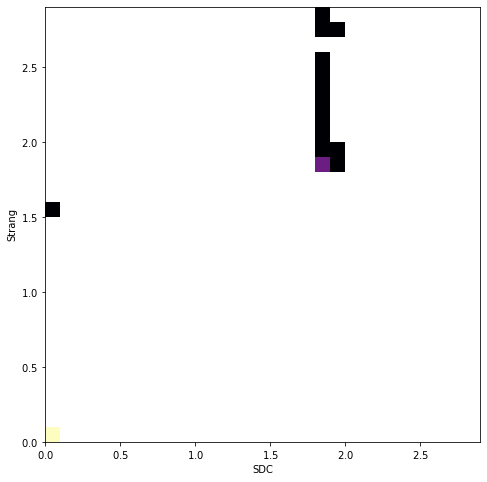

In [85]:
fig, ax = plt.subplots()

ax.hist2d(np.log10(lev1_sdc), np.log10(lev1_strang), bins=(np.arange(0, 3, 0.1), np.arange(0, 3, 0.1)), cmin=0.31, cmap="magma")
#ax.hist2d(lev1_sdc, lev1_strang, bins=(np.arange(0, 500, 5), np.arange(0, 500, 5)), cmin=1.0, cmap="magma")

ax.set_aspect("equal")
ax.set_ylabel("Strang")
ax.set_xlabel("SDC")
fig.set_size_inches(8, 8)

In [18]:
print(vals_strang.max())

165062.0 dimensionless


In [22]:
vals_sdc.max()

unyt_quantity(97., '(dimensionless)')

In [30]:
print(ind_strang)

[    0     1     2 ... 89597 89598 89599]


In [36]:
vals_strang[dd_strang["index", "grid_level"] == 0]

unyt_array([1., 1., 1., ..., 1., 1., 1.], '(dimensionless)')

In [37]:
lev1

unyt_array([1., 1., 1., ..., 1., 1., 1.], '(dimensionless)')

In [41]:
print(len(vals_sdc))

255488


In [52]:
np.mean(np.log10(lev1_sdc))

0.44846844956196974

# burn weights history

In [64]:
bw_strang = np.loadtxt("strang_burn_weights.out")
bw_sdc = np.loadtxt("sdc_burn_weights.out")

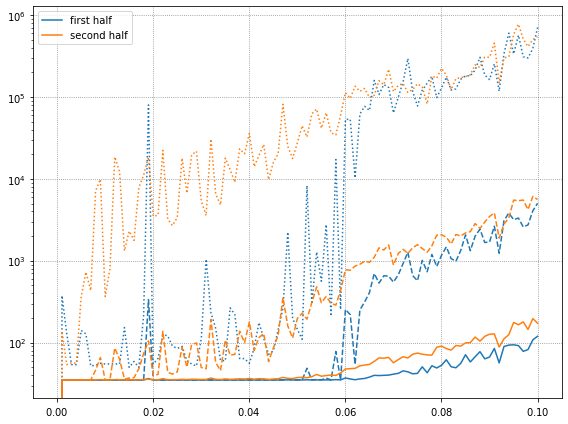

In [84]:
fig, ax = plt.subplots()

ax.plot(bw_strang[:,0], bw_strang[:,1], color="C0", label="first half")
ax.plot(bw_strang[:,0], bw_strang[:,2], color="C0", ls="--")
ax.plot(bw_strang[:,0], bw_strang[:,3], color="C0", ls=":")

ax.plot(bw_strang[:,0], bw_strang[:,4], color="C1", label="second half")
ax.plot(bw_strang[:,0], bw_strang[:,5], color="C1", ls="--")
ax.plot(bw_strang[:,0], bw_strang[:,6], color="C1", ls=":")

ax.set_yscale("log")
ax.grid(color="0.5", linestyle=":")
ax.legend()
fig.set_size_inches(8,6)
fig.tight_layout()
fig.savefig("strang_nrhs.pdf")
fig.savefig("strang_nrhs.png")

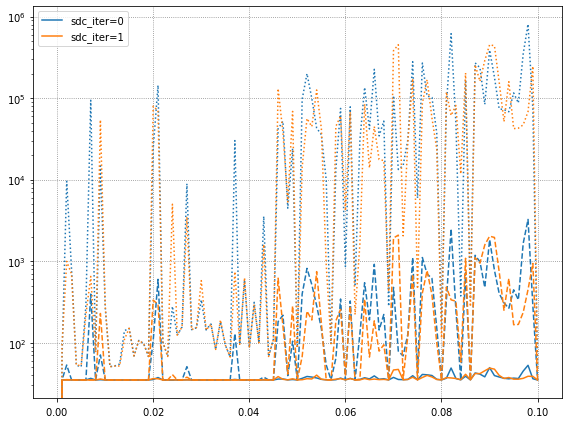

In [83]:
fig, ax = plt.subplots()

ax.plot(bw_sdc[:,0], bw_sdc[:,1], color="C0", label="sdc_iter=0")
ax.plot(bw_sdc[:,0], bw_sdc[:,2], color="C0", ls="--")
ax.plot(bw_sdc[:,0], bw_sdc[:,3], color="C0", ls=":")

ax.plot(bw_sdc[:,0], bw_sdc[:,4], color="C1", label="sdc_iter=1")
ax.plot(bw_sdc[:,0], bw_sdc[:,5], color="C1", ls="--")
ax.plot(bw_sdc[:,0], bw_sdc[:,6], color="C1", ls=":")

ax.set_yscale("log")
ax.grid(color="0.5", linestyle=":")
ax.legend()
fig.set_size_inches(8,6)
fig.tight_layout()
fig.savefig("sdc.pdf")
fig.savefig("sdc_nrhs.png")